In [ ]:
# Note: this only works for Ez polarization...

In [2]:
from fdfdpy.Fdfd import Fdfd
from nonlinear_solvers import born_solve, newton_solve
from fdfdpy.linalg import solver_direct
from optimization import _solve_nl

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
omega = 2*np.pi*200e12      # angular frequency (2pi)
dl = 0.02                   # grid size (units of L0, which defaults to 1e-6)
eps_r = np.ones((100,100))  # relative permittivity
eps_r[40:60, 40:60] = 5     # define box
NPML = [10, 10]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')

In [4]:
# set source to a value that makes things nonlinear but the simulations still converge
b = np.zeros(eps_r.shape)
b[40:60,30] = 4e2      

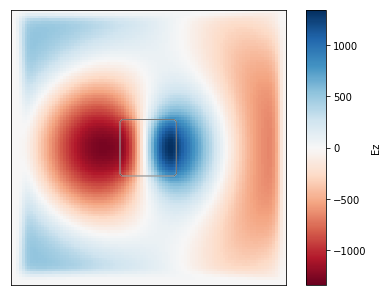

In [5]:
# Set simulation and show the linear solution
simulation = Fdfd(omega,eps_r,dl,NPML,pol)
simulation.solve_fields(b)
simulation.plt_re(outline=True, cbar=True);

In [6]:
# Define objective function and partial derivative
Jregion = np.zeros(eps_r.shape)
Jregion[45:50, 60] = 1
J = lambda Ez: np.sum(np.square(np.abs(Ez*Jregion)))
dJdE = lambda Ez: np.conj(Ez)*Jregion
# Define permittivity change region
design_region = np.zeros(eps_r.shape)
design_region[40:60, 40:60] = 1;

In [7]:
# Set nonlinearity 
chi3 = 2.8*1e-18        # Silcion in m^2/V^2 from Boyd's book
chi3_fdfd = chi3/simulation.L0**2        # In the units of the FDFD solver such that eps_nl = eps_r + 3*chi3_fdfd*|e|^2
nl_region = np.zeros(eps_r.shape)
nl_region[45:55, 45:55] = 1  # Nonliearity region, taken here different from design_region
# Define nonlinear function
kerr_nonlinearity = lambda e: 3*chi3_fdfd*np.square(np.abs(e))
# Define the partial derivative of the nonlinear function w.r.t. e
kerr_nl_de = lambda e: 3*chi3_fdfd*np.conj(e)

the simulation did not converge, reached 1.486626829229857e-07


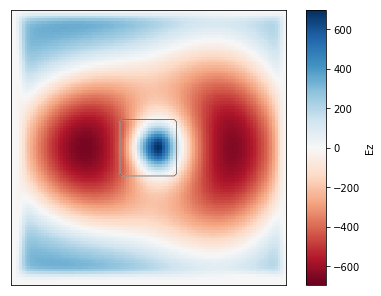

In [8]:
# Solve simulation using Born and plot Ez; it's barely converging
simulation = Fdfd(omega,eps_r,dl,NPML,pol)# set source and solve for electromagnetic fields
(convergence_array) = _solve_nl(simulation, b, kerr_nonlinearity, nl_region, solver='born')
simulation.plt_re(outline=True, cbar=True);

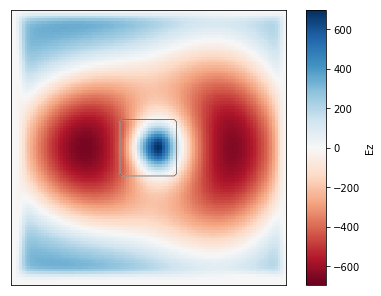

In [9]:
# Solve simulation using Newton and plot Ez
simulation = Fdfd(omega,eps_r,dl,NPML,pol)    # reset linear simulation
(convergence_array) = _solve_nl(simulation, b, kerr_nonlinearity, nl_region, kerr_nl_de, solver='newton')
simulation.plt_re(outline=True, cbar=True);

In [10]:
# Compute numerical gradient
deps = 1e-8
simulation.reset_eps(eps_r + deps*design_region)
_solve_nl(simulation, b, kerr_nonlinearity, nl_region, kerr_nl_de, solver='newton')
Ezf = simulation.fields['Ez']
simulation.reset_eps(eps_r - deps*design_region)
_solve_nl(simulation, b, kerr_nonlinearity, nl_region, kerr_nl_de, solver='newton')
Ezb = simulation.fields['Ez']
grad_num = (J(Ezf) - J(Ezb))/2/deps

In [11]:
# Adjoint computation for the Ez polarization 
# Note: this is already the point-by-point computation! dJdeps has the same size as eps_r 
# and has the derivative with respect to every pixel. 
from adjoint import *
simulation.reset_eps(eps_r)
_solve_nl(simulation, b, kerr_nonlinearity, nl_region, kerr_nl_de, solver='newton')
dJdeps = dJdeps_nonlinear(simulation, design_region, J, dJdE, kerr_nonlinearity, nl_region, kerr_nl_de)

print('numerical gradient', grad_num)
print('adjoint gradient', dJdeps.sum())
print('norm difference ', abs(dJdeps.sum()-grad_num)/abs(grad_num))

numerical gradient -780276.6282111406
adjoint gradient -780283.848364252
norm difference  9.253324847029295e-06


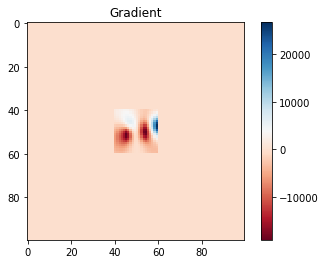

In [12]:
# plot
plt.imshow(dJdeps, cmap='RdBu')
plt.colorbar()
plt.title('Gradient')
plt.show()